# Impact of COVID-19 on In-Store and E-commerce Sales


## Introduction:
The COVID-19 pandemic has profoundly impacted global economies and consumer behaviors, leading to a significant shift in the retail landscape. E-commerce, in particular, has experienced accelerated growth as lockdowns, social distancing measures, and changes in consumer preferences have driven more people to shop online. This project aims to analyze the performance of e-commerce during the COVID-19 pandemic, comparing it with the performance of traditional brick-and-mortar stores, to understand the broader implications for the retail industry.

## Scope:
This project will focus on the following key areas:
#### Pre COVID-19 Trend: 
Establish a baseline by analyzing e-commerce and brick-and-mortar retail performance before the pandemic (2019 and earlier).
#### Impact During COVID-19: 
Examine the changes in consumer behavior and retail sales during the peak of the pandemic (2020-2021), highlighting key trends and growth areas in e-commerce.
#### Post COVID-19 Trend: 
Analyze the performance of e-commerce and brick-and-mortar stores in the aftermath of the pandemic, identifying lasting changes and new trends in the retail industry.
#### Comparative Analysis: 
Perform a comparative analysis of e-commerce and traditional retail sales across the three phases (pre, during, and post-COVID-19) to quantify the impact of the pandemic on both sectors.
#### Geographical Insights: 
Provide regional insights to identify variations in the impact of COVID-19 on retail sales performance across different areas.

## Research Questions:

In this project, we will address key questions such as:

1. How has the COVID-19 pandemic affected the performance of e-commerce compared to traditional brick-and-mortar retail?
2. What are the long-term implications for consumer behavior in the retail industry?
3. What were the most and least pandemic sensitive industry?
4. API: Retail sales according to provinces in Canada

In [114]:
#Data Acquisition

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
import os
import numpy as np
import requests
import hvplot.pandas

In [115]:
# Load the CSV file from the Resourced folder
ecom_df = pd.read_csv('Resources/ecommerce.csv')
ecom_df.head()

,REF_DATE,GEO,DGUID,Sales,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2016-01,Canada,2016A000011124,"Retail trade, unadjusted\n [44-453]",Dollars,81,thousands,3,v108795018,1.1,37415147,A,NaN,NaN,0
1,2016-01,Canada,2016A000011124,"Electronic shopping and mail-order houses, una...",Dollars,81,thousands,3,v108795019,1.2,679612,B,NaN,NaN,0
2,2016-01,Canada,2016A000011124,"Retail E-commerce sales, unadjusted\n",Dollars,81,thousands,3,v108795020,1.3,877354,A,NaN,NaN,0
3,2016-01,Canada,2016A000011124,"Retail E-commerce sales, seasonally adjusted\n",Dollars,81,thousands,3,v1257881695,1.4,977198,A,NaN,NaN,0
4,2016-02,Canada,2016A000011124,"Retail trade, unadjusted\n [44-453]",Dollars,81,thousands,3,v108795018,1.1,36815980,A,NaN,NaN,0


In [116]:
# Display basic information about the data
ecom_df.info()

# Display summary statistics
ecom_df.describe(include='all')

# Check for missing values
ecom_df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   REF_DATE       336 non-null    object 
 1   GEO            336 non-null    object 
 2   DGUID          336 non-null    object 
 3   Sales          336 non-null    object 
 4   UOM            336 non-null    object 
 5   UOM_ID         336 non-null    int64  
 6   SCALAR_FACTOR  336 non-null    object 
 7   SCALAR_ID      336 non-null    int64  
 8   VECTOR         336 non-null    object 
 9   COORDINATE     336 non-null    float64
 10  VALUE          336 non-null    int64  
 11  STATUS         336 non-null    object 
 12  SYMBOL         0 non-null      float64
 13  TERMINATED     0 non-null      float64
 14  DECIMALS       336 non-null    int64  
dtypes: float64(3), int64(4), object(8)
memory usage: 39.5+ KB


REF_DATE           0
GEO                0
DGUID              0
Sales              0
UOM                0
UOM_ID             0
SCALAR_FACTOR      0
SCALAR_ID          0
VECTOR             0
COORDINATE         0
VALUE              0
STATUS             0
SYMBOL           336
TERMINATED       336
DECIMALS           0
dtype: int64

In [117]:
# Remove columns with 100% missing values
cleaned_df = ecom_df.drop(columns=['SYMBOL', 'TERMINATED'])

# Convert REF_DATE to datetime
cleaned_df['REF_DATE'] = pd.to_datetime(cleaned_df['REF_DATE'])

# Remove columns with only one unique value
cleaned_df = cleaned_df.drop(columns=['GEO', 'DGUID', 'UOM', 'SCALAR_FACTOR', 'UOM_ID'])

# Handle duplicates
cleaned_df = cleaned_df.drop_duplicates()

# Remove newline characters from the Sales column
cleaned_df['Sales'] = cleaned_df['Sales'].str.replace('\n', '', regex=True)


# Clip outliers in the VALUE column
cleaned_df['VALUE'] = cleaned_df['VALUE'].clip(lower=ecom_df['VALUE'].quantile(0.01), upper=ecom_df['VALUE'].quantile(0.99))

# Display the cleaned data
cleaned_df.head()

,REF_DATE,Sales,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,DECIMALS
0,2016-01-01,"Retail trade, unadjusted [44-453]",3,v108795018,1.1,37415147.0,A,0
1,2016-01-01,"Electronic shopping and mail-order houses, una...",3,v108795019,1.2,679612.0,B,0
2,2016-01-01,"Retail E-commerce sales, unadjusted",3,v108795020,1.3,877354.0,A,0
3,2016-01-01,"Retail E-commerce sales, seasonally adjusted",3,v1257881695,1.4,977198.0,A,0
4,2016-02-01,"Retail trade, unadjusted [44-453]",3,v108795018,1.1,36815980.0,A,0


In [118]:
unique_dates = sorted(cleaned_df['REF_DATE'].unique())
unique_dates

num_unique_months = cleaned_df["REF_DATE"].nunique()
num_unique_months

categories = cleaned_df["Sales"].unique()

print(f"There are {num_unique_months} unique months in this data frame ")
print(f"These are the categoires in the data frame:\n  {categories} ")

There are 84 unique months in this data frame 
These are the categoires in the data frame:
  ['Retail trade, unadjusted [44-453]'
 'Electronic shopping and mail-order houses, unadjusted [45411]'
 'Retail E-commerce sales, unadjusted'
 'Retail E-commerce sales, seasonally adjusted'] 


## Seeing Data from different angles

In [119]:

# Assuming cleaned_df is your DataFrame

# Convert REF_DATE to string type
cleaned_df['REF_DATE'] = cleaned_df['REF_DATE'].astype(str)

# Extract the year from the REF_DATE column
cleaned_df['Year'] = cleaned_df['REF_DATE'].str[:4]

# Group by Sales category and Year, then sum the VALUE column
sales_by_category_year = cleaned_df.groupby(['Sales', 'Year'])['VALUE'].sum().reset_index()

# Scale the VALUE column to millions
sales_by_category_year['VALUE'] = sales_by_category_year['VALUE'] / 1_000_000

# Pivot the table to have years as columns
sales_pivot = sales_by_category_year.pivot(index='Sales', columns='Year', values='VALUE').reset_index()

# Display the pivot table
sales_pivot


Year,Sales,2016,2017,2018,2019,2020,2021,2022
0,"Electronic shopping and mail-order houses, una...",8.908062,9.875625,12.494330,16.542989,24.982113,28.587807,29.470259
1,"Retail E-commerce sales, seasonally adjusted",12.321519,15.759355,18.247294,22.485628,39.348090,46.387959,42.304637
2,"Retail E-commerce sales, unadjusted",12.321519,15.759352,18.247294,22.485630,39.348090,46.387958,42.389200
3,"Retail trade, unadjusted [44-453]",549.711319,589.173361,607.899907,616.544408,608.330374,680.101036,727.395076


The differences among the above categories 
1. "Electronic shopping and mail-order houses, unadjusted," 
2. "Retail E-commerce sales, seasonally adjusted," 
3. "Retail E-commerce sales, unadjusted,"
4. "Retail trade, unadjusted [44-453]" 

expressed in the Sales column relate to the type of retail activities they represent and whether the sales figures are seasonally adjusted or not

For this analysis we will take 3 categories: Retail E-commerce sales unadjusted, Retail E-commerce sales unadjusted, and Retail trade unadjusted [44-453]: which means that the sales figures are raw data and have not been adjusted for seasonal variations, such as increased shopping during holidays.


Please note the following distinctions for each category:

1. Electronic shopping and mail-order houses: Encompasses companies that might not have physical stores and conduct most or all of their sales online or through catalogs. i.e amazon

2. Retail E-commerce sales: Includes sales from both pure e-commerce retailers and brick-and-mortar retailers with an online presence. ie. Walmart

3. Retail trade: Unlike the other categories that focus on specific sales channels or types of businesses, "Retail trade, unadjusted [44-453]" covers the entire retail industry under the North American Industry Classification System (NAICS) codes 44-453.


In [120]:
ecom_categories = [
    "Retail E-commerce sales, unadjusted",
    "Electronic shopping and mail-order houses, unadjusted [45411]"
]

retail_category = "Retail trade, unadjusted [44-453]"

# Extract e-commerce sales data
ecom_sales = cleaned_df[cleaned_df['Sales'].isin(ecom_categories)]

# Extract retail sales data
retail_sales = cleaned_df[cleaned_df['Sales'] == retail_category]

# Summarize e-commerce sales
ecom_summary = ecom_sales.groupby(['Sales', 'Year'])['VALUE'].sum().reset_index()
ecom_summary['VALUE'] = ecom_summary['VALUE'] / 1_000_000
ecom_summary = ecom_summary.pivot(index='Year', columns='Sales', values='VALUE').reset_index()

# Summarize retail sales
retail_summary = retail_sales.groupby(['Year'])['VALUE'].sum().reset_index()
retail_summary['VALUE'] = retail_summary['VALUE'] / 1_000_000
retail_summary.rename(columns={'VALUE': 'Retail Sales (in millions)'}, inplace=True)

# Combine summaries for comparison
comparison = pd.merge(ecom_summary, retail_summary, on='Year', how='outer')

# Calculate percentage change for each column
for column in comparison.columns[1:]:  # Skip ‘Year’ column
    comparison[f'{column} % Change'] = comparison[column].pct_change() * 100

# Display the comparison table
comparison

,Year,"Electronic shopping and mail-order houses, unadjusted [45411]","Retail E-commerce sales, unadjusted",Retail Sales (in millions),"Electronic shopping and mail-order houses, unadjusted [45411] % Change","Retail E-commerce sales, unadjusted % Change",Retail Sales (in millions) % Change
0,2016,8.908062,12.321519,549.711319,NaN,NaN,NaN
1,2017,9.875625,15.759352,589.173361,10.861657,27.901049,7.178685
2,2018,12.494330,18.247294,607.899907,26.516854,15.787083,3.178444
3,2019,16.542989,22.485630,616.544408,32.403970,23.227203,1.422027
4,2020,24.982113,39.348090,608.330374,51.013296,74.992162,-1.332270
5,2021,28.587807,46.387958,680.101036,14.433103,17.891257,11.797974
6,2022,29.470259,42.389200,727.395076,3.086813,-8.620250,6.953973


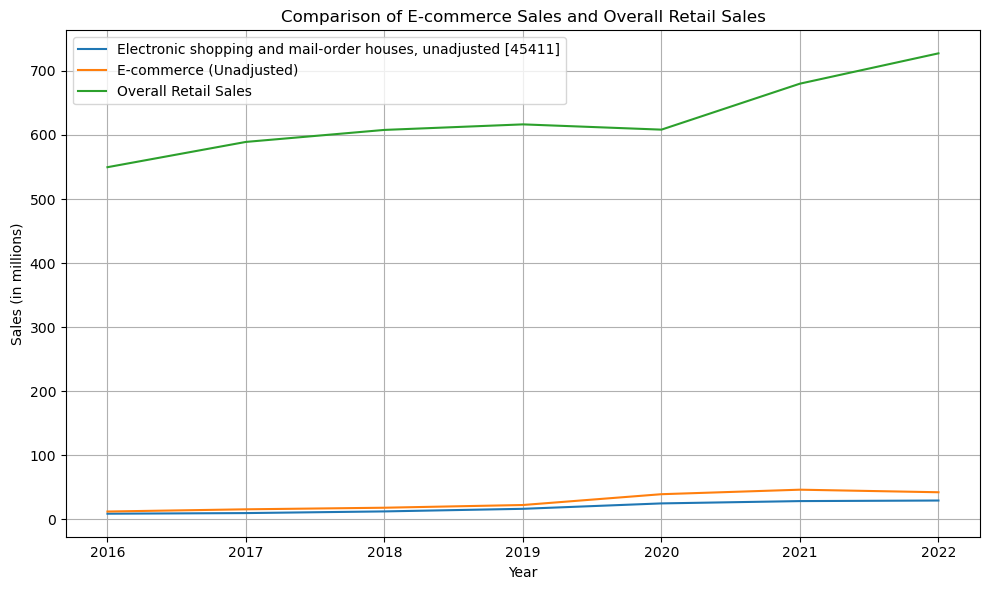

In [121]:
plt.figure(figsize=(10, 6))

# Plot the e-commerce sales
plt.plot(comparison['Year'], comparison['Electronic shopping and mail-order houses, unadjusted [45411]'], label='Electronic shopping and mail-order houses, unadjusted [45411]')
plt.plot(comparison['Year'], comparison['Retail E-commerce sales, unadjusted'], label='E-commerce (Unadjusted)')

# Plot the overall retail sales
plt.plot(comparison['Year'], comparison['Retail Sales (in millions)'], label='Overall Retail Sales')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Sales (in millions)')
plt.title('Comparison of E-commerce Sales and Overall Retail Sales')
plt.legend()

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()


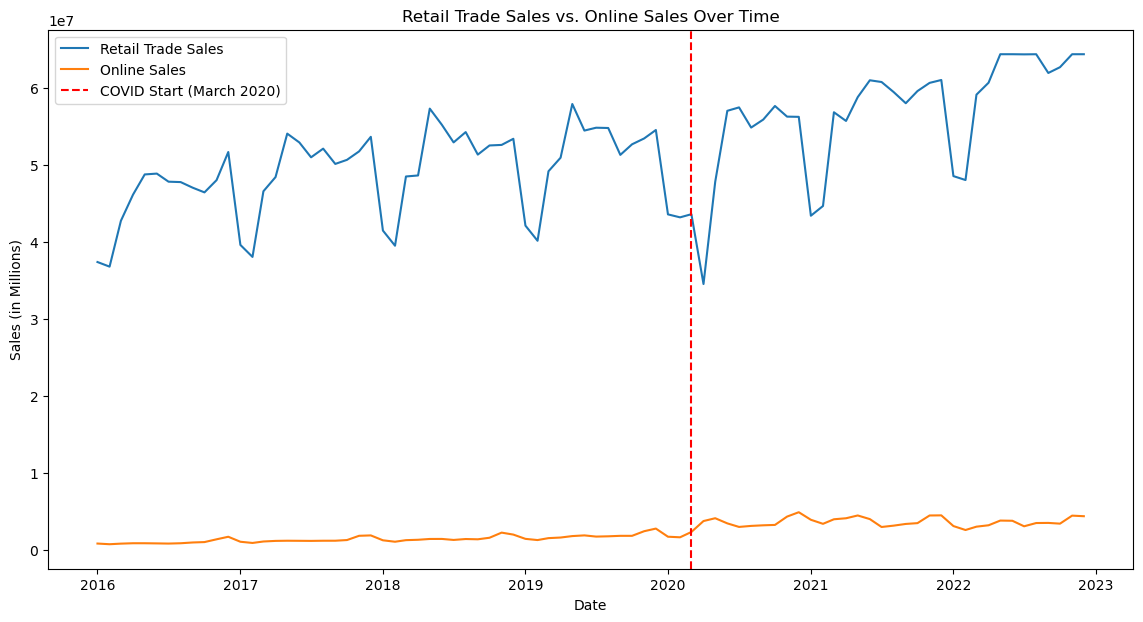

(-5.288056821151404,
 2.0194261432710503e-06,
 -18.255670755409394,
 2.6795980272813457e-25)

In [122]:
cleaned_df['REF_DATE'] = pd.to_datetime(cleaned_df['REF_DATE'])

# Define the COVID-19 impact period
covid_start = pd.to_datetime('2020-03-01')

# Split the data into pre-COVID and during-COVID periods
pre_covid = cleaned_df[cleaned_df['REF_DATE'] < covid_start]
during_covid = cleaned_df[cleaned_df['REF_DATE'] >= covid_start]

# Visualize the trends
plt.figure(figsize=(14, 7))

# Retail trade sales
retail_sales = cleaned_df[cleaned_df['Sales'].str.contains('Retail trade, unadjusted')]
plt.plot(retail_sales['REF_DATE'], retail_sales['VALUE'], label='Retail Trade Sales')

# Online sales
online_sales = cleaned_df[cleaned_df['Sales'].str.contains('Retail E-commerce sales, unadjusted')]
plt.plot(online_sales['REF_DATE'], online_sales['VALUE'], label='Online Sales')

plt.axvline(covid_start, color='red', linestyle='--', label='COVID Start (March 2020)')
plt.xlabel('Date')
plt.ylabel('Sales (in Millions)')
plt.title('Retail Trade Sales vs. Online Sales Over Time')
plt.legend()
plt.show()

# Statistical analysis
# Compare the means before and during COVID for retail sales
pre_covid_retail = pre_covid[pre_covid['Sales'].str.contains('Retail trade, unadjusted')]['VALUE']
during_covid_retail = during_covid[during_covid['Sales'].str.contains('Retail trade, unadjusted')]['VALUE']
t_stat_retail, p_val_retail = ttest_ind(pre_covid_retail, during_covid_retail, equal_var=False)

# Compare the means before and during COVID for online sales
pre_covid_online = pre_covid[pre_covid['Sales'].str.contains('Retail E-commerce sales, unadjusted')]['VALUE']
during_covid_online = during_covid[during_covid['Sales'].str.contains('Retail E-commerce sales, unadjusted')]['VALUE']
t_stat_online, p_val_online = ttest_ind(pre_covid_online, during_covid_online, equal_var=False)

t_stat_retail, p_val_retail, t_stat_online, p_val_online


## General Observations
1. Retail Trade Sales (Blue Line):
-Trend: Fluctuating but generally increasing from 2016 to 2023.
-Seasonality: Clear seasonal peaks and troughs, likely due to holidays 
and other annual cycles.
-COVID-19 Impact: Significant dip in March 2020, followed by recovery
and growth.
2. Online Sales (Orange Line):
-Trend: Relatively flat from 2016 to early 2020.
-COVID-19 Impact: Slight increase starting in March 2020, but not as 
dramatic as expected.

# Specific Observations
1. Pre-COVID-19 (2016 - Early 2020):
-Retail sales show significant seasonal variability.
-Online sales remain steady and low compared to retail.
2. During and Post-COVID-19 (March 2020 - 2023):
-Retail sales dip at the start of the pandemic but recover and grow.
-Online sales increase modestly, reflecting a shift to online shopping.

# Insights
1. Retail Resilience: Quick recovery and continued growth after the initial 
COVID-19 dip show adaptability.
2. Modest Online Growth: Increase in online sales is evident but not dramatic,
suggesting many consumers still preferred in-store shopping.

# Recommendations
1. For Retail:
-Invest in hybrid shopping models.
-Enhance resilience strategies for future disruptions.
2. For Online Sales:
-Improve scalability and infrastructure.
-Target marketing strategies during peak demand periods

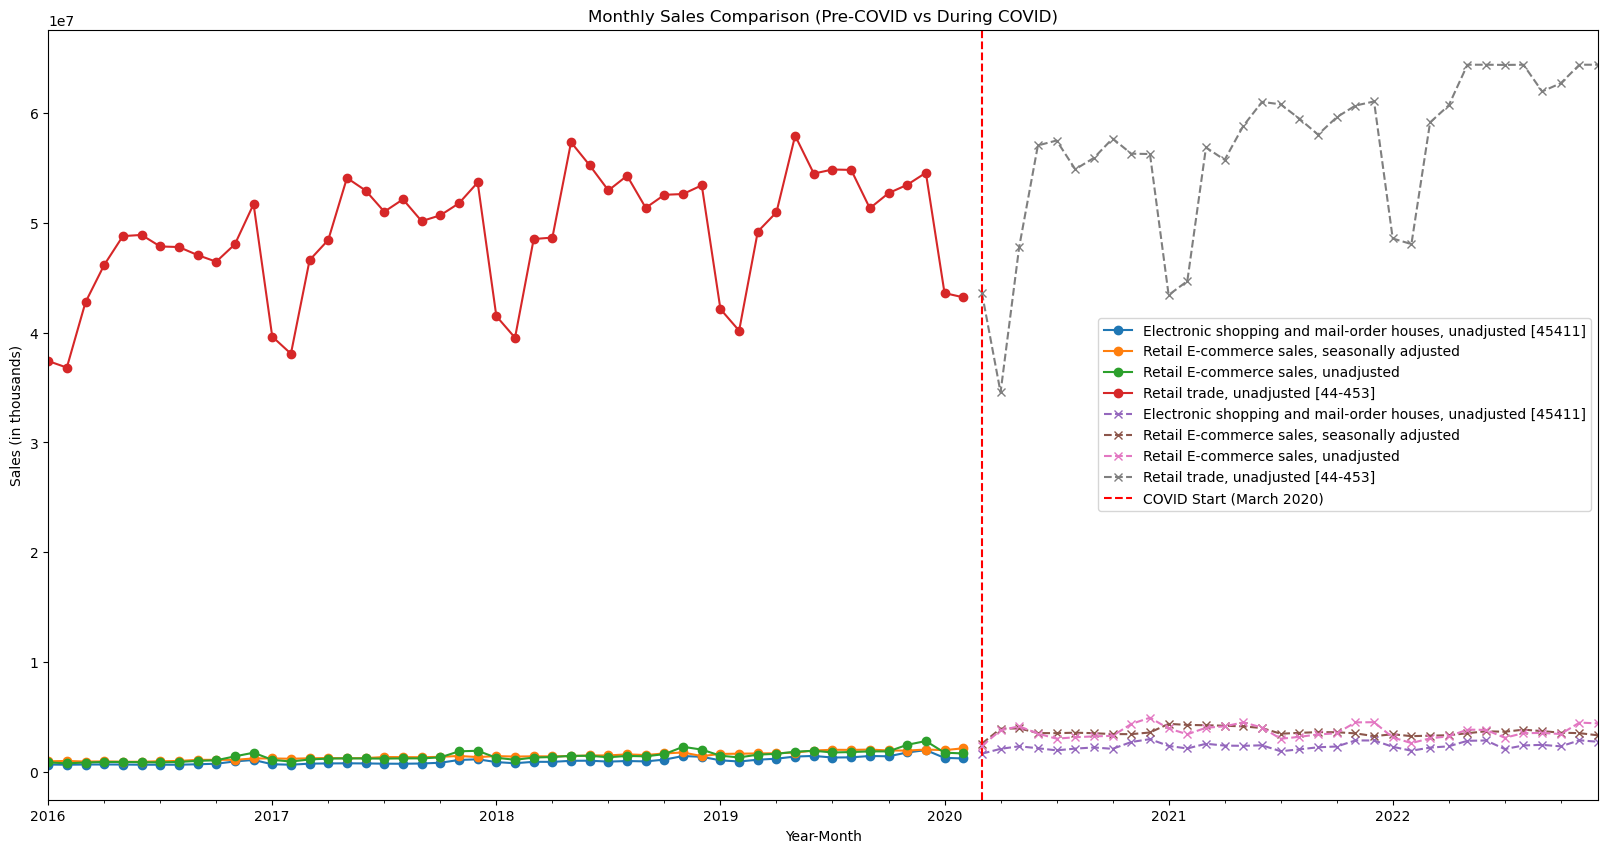

In [123]:
# Assuming cleaned_df is your DataFrame

# Convert 'REF_DATE' column to datetime if not already done
cleaned_df['REF_DATE'] = pd.to_datetime(cleaned_df['REF_DATE'])

# Group data by month and year for comparison
cleaned_df['YearMonth'] = cleaned_df['REF_DATE'].dt.to_period('M')

# Aggregate sales by month
monthly_sales = cleaned_df.groupby(['YearMonth', 'Sales'])['VALUE'].sum().unstack()

# Split the data into pre-COVID and during-COVID periods
pre_covid_monthly = monthly_sales[monthly_sales.index < '2020-03']
during_covid_monthly = monthly_sales[monthly_sales.index >= '2020-03']

# Plot monthly sales comparison
plt.figure(figsize=(20, 10))

# Pre-COVID
pre_covid_monthly.plot(ax=plt.gca(), linestyle='-', marker='o', title='Monthly Sales Comparison (Pre-COVID vs During COVID)')

# During-COVID
during_covid_monthly.plot(ax=plt.gca(), linestyle='--', marker='x')

plt.axvline(pd.to_datetime('2020-03'), color='red', linestyle='--', label='COVID Start (March 2020)')
plt.xlabel('Year-Month')
plt.ylabel('Sales (in thousands)')
plt.legend()
plt.show()


## General Observations
1. Retail Trade Sales (Red Line):
-Trend: Fluctuating but generally increasing from 2016 to early 2020.
-COVID-19 Impact: Sharp dip at the start of COVID-19, followed by 
recovery and steady growth.
2. Online Sales (Blue, Orange, Green Lines):
-Trend: Relatively flat from 2016 to early 2020.
-COVID-19 Impact: Noticeable increase starting in March 2020, with 
more significant growth compared to pre-COVID-19.
# Specific Observations
1. Pre-COVID-19 (2016 - Early 2020):
-Retail trade sales show seasonal variability with periodic peaks and 
troughs.
-Online sales are relatively stable and low.
2. During and Post-COVID-19 (March 2020 - 2023):
-Retail trade sales initially drop but then recover and continue to grow.
-Online sales show a clear upward trend, indicating increased reliance 
on online shopping.
# Insights
1. Retail Resilience: Despite the initial dip due to COVID-19, retail sales 
recovered quickly, showing adaptability.
2. Shift to Online Sales: The pandemic accelerated the growth of online sales,
reflecting a shift in consumer behavior.
# Recommendations
1. For Retail:
-Invest in hybrid shopping models combining in-store and online 
experiences.
-Enhance strategies to quickly adapt to disruptions.
2. For Online Sales:
-Scale up infrastructure to handle increased demand.
-Target marketing efforts during periods of high online activity

<Figure size 1400x700 with 0 Axes>

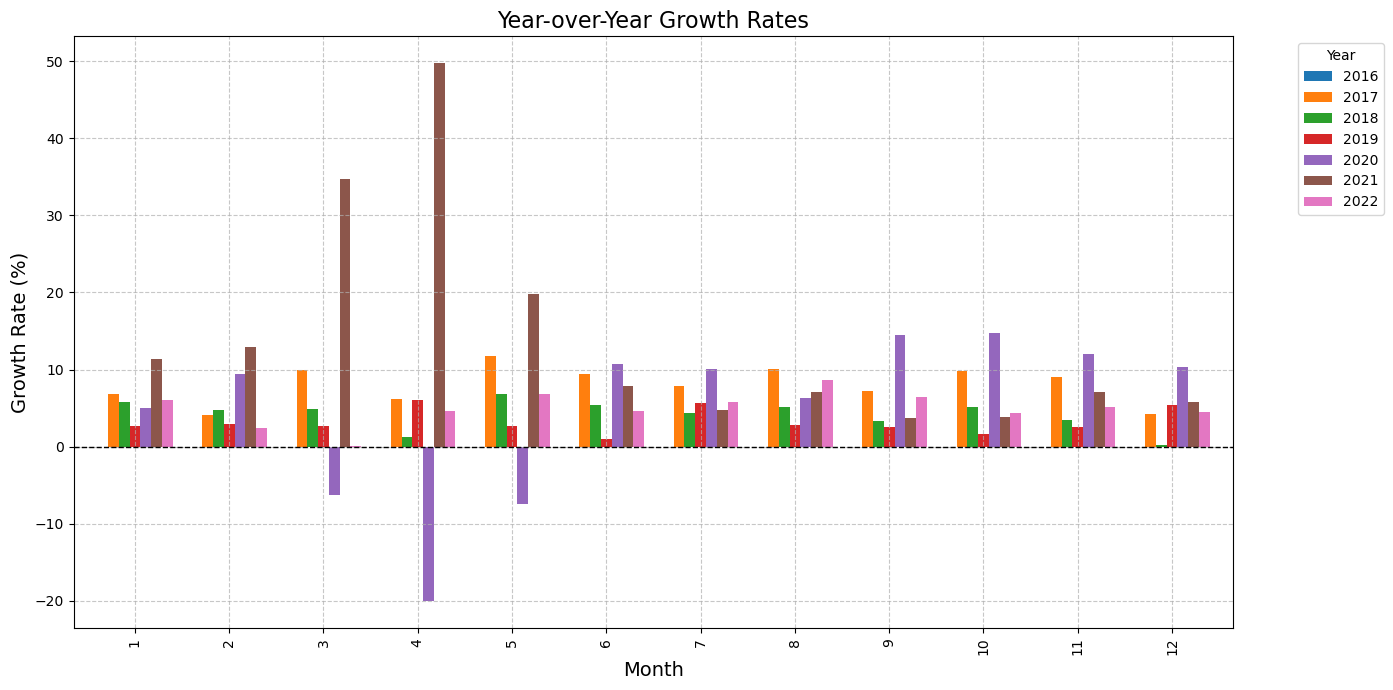

In [124]:

cleaned_df['REF_DATE'] = pd.to_datetime(cleaned_df['REF_DATE'])
# Calculate year and month
cleaned_df['Year'] = cleaned_df['REF_DATE'].dt.year
cleaned_df['Month'] = cleaned_df['REF_DATE'].dt.month
# Create pivot table for year-over-year analysis
yoy_growth = cleaned_df.pivot_table(values='VALUE', index='Month', columns='Year', aggfunc='sum')
# Calculate percentage growth year-over-year
yoy_growth = yoy_growth.pct_change(axis='columns') * 100
# Plot YoY growth rates
plt.figure(figsize=(14, 7))
ax = yoy_growth.plot(kind='bar', figsize=(14, 7), width=0.8)
# Add title and labels
ax.set_title('Year-over-Year Growth Rates', fontsize=16)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Growth Rate (%)', fontsize=14)
# Add grid lines
ax.grid(True, linestyle='--', alpha=0.7)
# Highlight significant points (e.g., during COVID-19)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
# Improve the legend
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
# Display the plot
plt.tight_layout()
plt.show()





## General Observations
1. Year-over-Year Growth Rates:
-The chart shows monthly growth rates for each year from 2016 to 2022
-Positive growth rates are above the 0% line, while negative growth 
rates are below it.
# Specific Observations
1. Pre-COVID-19 (2016 - Early 2020):
-Growth rates are generally positive, indicating steady growth year-
over-year.
-Some fluctuations are observed, with certain months showing higher 
growth compared to others.
2. During and Post-COVID-19 (March 2020 - 2022):
-2020: Noticeable negative growth in April, likely due to the impact of 
COVID-19 lockdowns.
-2021: Significant positive growth in some months, indicating recovery 
and possibly a rebound effect as restrictions were lifted.
-2022: Continued positive growth, suggesting a stabilization and return 
to a growth trajectory.
# Insights
1. Impact of COVID-19: The pandemic caused a sharp decline in growth rates around 
March-April 2020. However, subsequent years show a strong recovery with some months
experiencing high growth rates.
2. Recovery Trends: The sharp positive growth in 2021 suggests a rebound effect as 
businesses and consumers adapted to the new normal. Growth rates in 2022 indicate a 
return to more stable growth patterns.
# Recommendations
1. For Retail Businesses:
-Leverage insights from periods of high growth to identify successful 
strategies.
-Prepare for potential future disruptions by building resilience based on 
learnings from the COVID-19 period.
2. For Policy Makers and Analysts:
-Use growth rate trends to inform economic policies and support 
measures during recovery periods.
-Monitor year-over-year growth rates to anticipate and mitigate the 
impact of future disruptions.

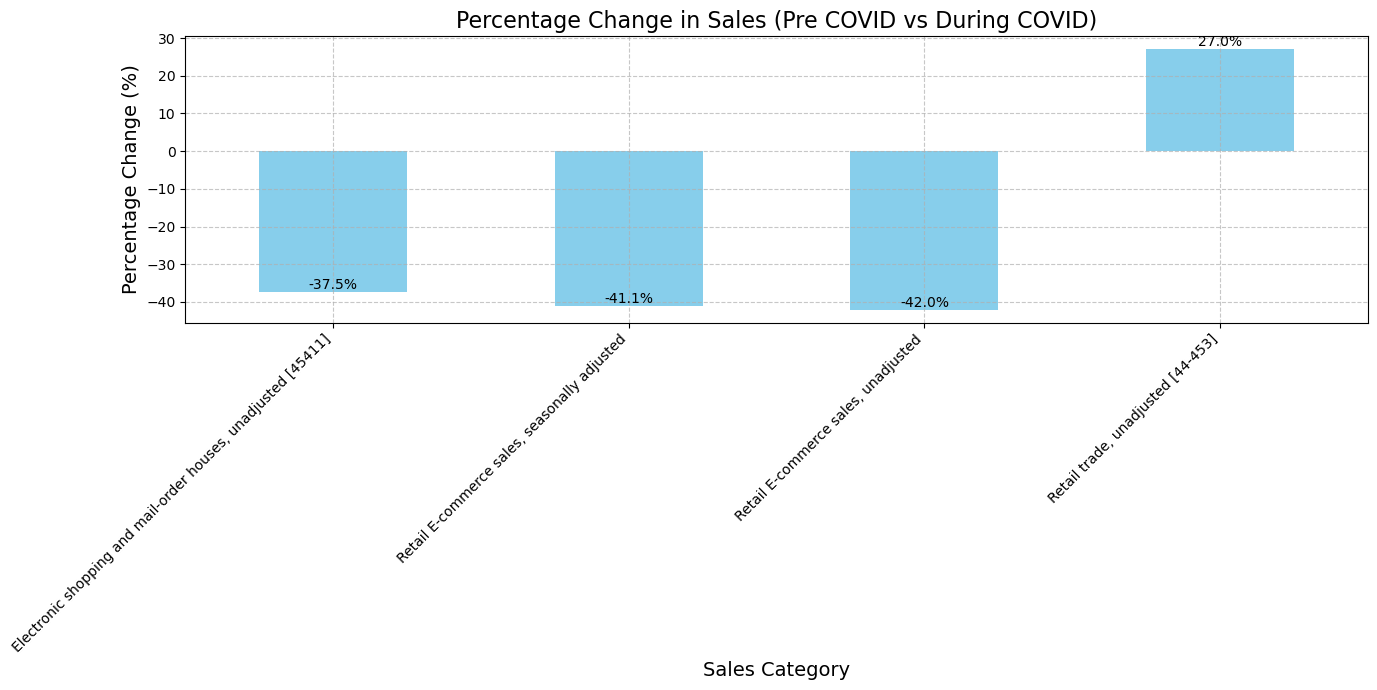

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


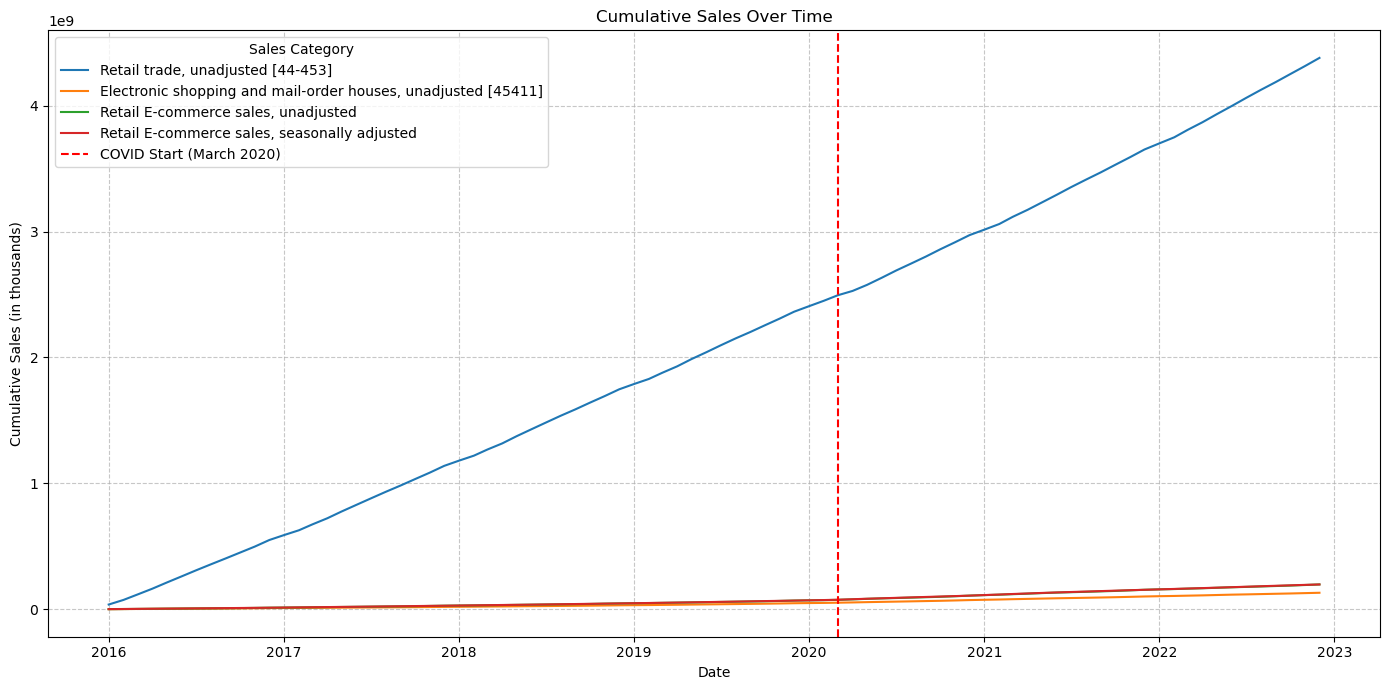

In [125]:
# Calculate percentage change in sales
cleaned_df['Period'] = cleaned_df['REF_DATE'].apply(lambda x: 'During COVID' if x >= pd.to_datetime('2020-03-01') else 'Pre COVID')
sales_change = cleaned_df.groupby(['Sales', 'Period'])['VALUE'].sum().unstack().pct_change(axis='columns').iloc[:, 1] * 100

# Plot percentage change in sales
plt.figure(figsize=(14, 7))
ax1 = sales_change.plot(kind='bar', color='skyblue', legend=False)
ax1.set_title('Percentage Change in Sales (Pre COVID vs During COVID)', fontsize=16)
ax1.set_xlabel('Sales Category', fontsize=14)
ax1.set_ylabel('Percentage Change (%)', fontsize=14)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.grid(True, linestyle='--', alpha=0.7)
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

# Calculate cumulative sales
cleaned_df['Cumulative_Sales'] = cleaned_df.groupby('Sales')['VALUE'].cumsum()

# Plot cumulative sales
plt.figure(figsize=(14, 7))
sns.lineplot(x='REF_DATE', y='Cumulative_Sales', hue='Sales', data=cleaned_df)
plt.axvline(pd.to_datetime('2020-03'), color='red', linestyle='--', label='COVID Start (March 2020)')
plt.title('Cumulative Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Sales (in thousands)')
plt.legend(title='Sales Category')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## General Observations
1. Cumulative Sales Over Time:
-The chart shows the cumulative sales for different categories from 
2016 to 2023.
-A vertical red dashed line marks the start of COVID-19 in March 2020.
# Specific Observations
1. Retail Trade (Blue Line):
-Trend: Steady and significant increase over time.
-COVID-19 Impact: Continuation of the growth trend with no 
noticeable disruption.
2. E-commerce Categories:
-Electronic shopping and mail-order houses (Orange Line):
Trend: Slight upward trend, more noticeable post-2020.
-Retail E-commerce sales (Green and Red Lines):
Trend: Gradual increase with a slight uptick post-2020.
# Insights
1. Resilience of Retail Trade:
-Retail trade shows strong and continuous growth, unaffected by the 
pandemic.
2. Growth in E-commerce:
-E-commerce categories show a modest increase in cumulative sales, 
with a more noticeable rise after 2020, indicating a shift towards online
shopping during the pandemic.
# Recommendations
1. For Retail Trade:
-Continue leveraging strategies that have driven consistent growth.
-Maintain resilience and adaptability to handle future disruptions.
2. For E-commerce:
-Capitalize on the growth trend by enhancing online shopping 
Experiences.
-Invest in infrastructure to support increased demand and improve 
supply chain resilience.

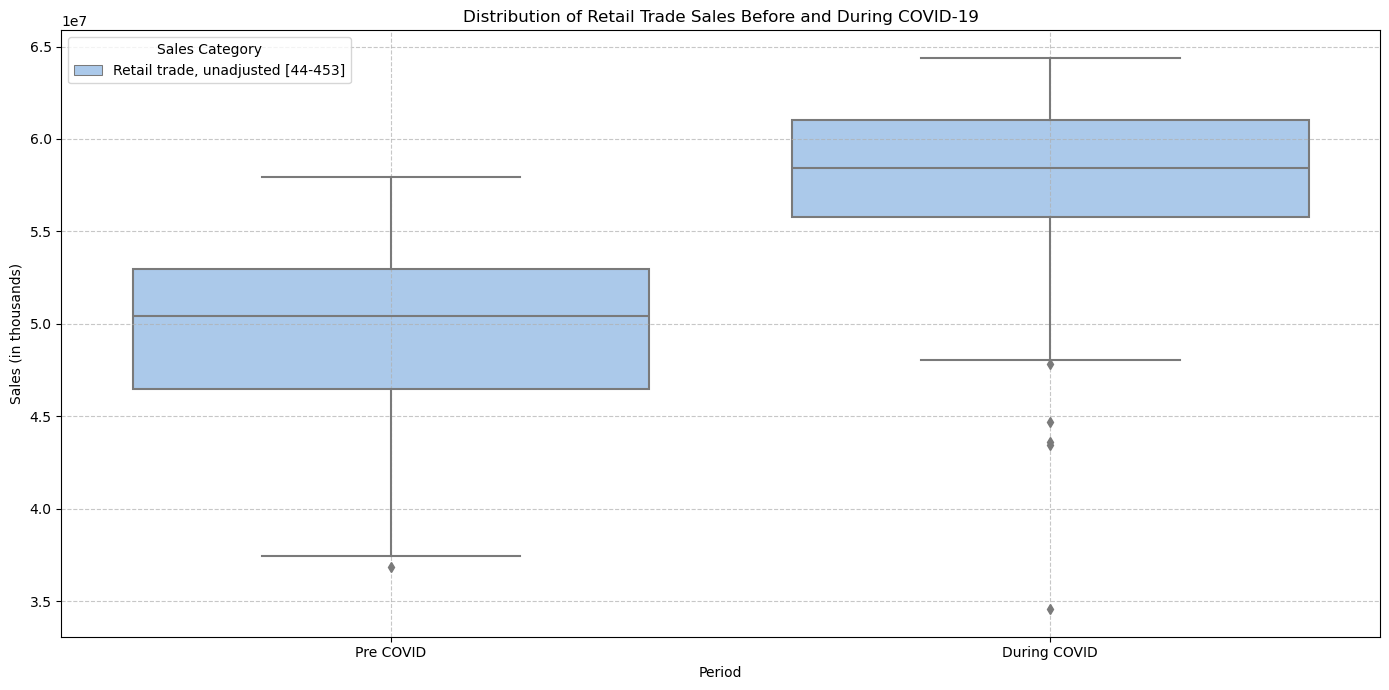

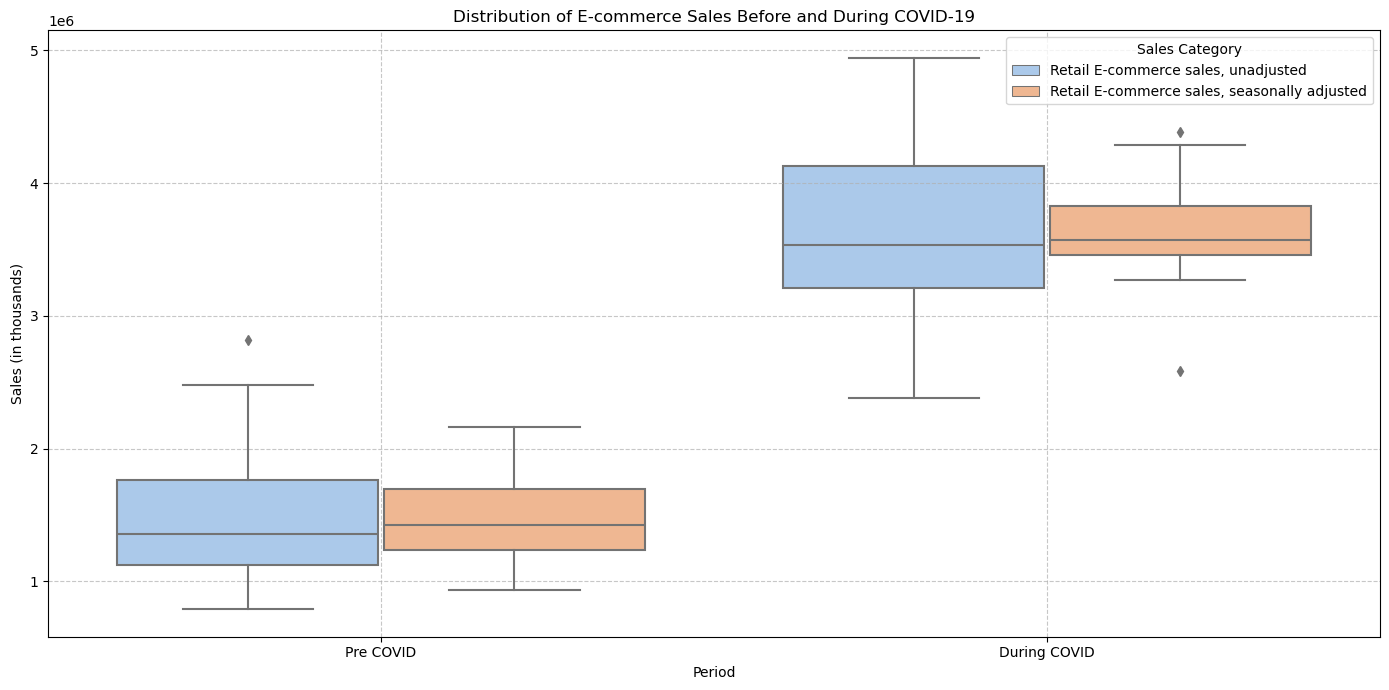

In [126]:
# Calculate the distribution of sales before and during COVID-19
cleaned_df['Period'] = cleaned_df['REF_DATE'].apply(lambda x: 'During COVID' if x >= pd.to_datetime('2020-03-01') else 'Pre COVID')

# Filter data for Retail Trade and E-commerce Sales
retail_trade = cleaned_df[cleaned_df['Sales'].str.contains('Retail trade, unadjusted')]
ecommerce_sales = cleaned_df[cleaned_df['Sales'].str.contains('E-commerce')]

# Plot distribution of sales for Retail Trade
plt.figure(figsize=(14, 7))
sns.boxplot(x='Period', y='VALUE', hue='Sales', data=retail_trade, palette='pastel')
plt.title('Distribution of Retail Trade Sales Before and During COVID-19')
plt.xlabel('Period')
plt.ylabel('Sales (in thousands)')
plt.legend(title='Sales Category')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot distribution of sales for E-commerce Sales
plt.figure(figsize=(14, 7))
sns.boxplot(x='Period', y='VALUE', hue='Sales', data=ecommerce_sales, palette='pastel')
plt.title('Distribution of E-commerce Sales Before and During COVID-19')
plt.xlabel('Period')
plt.ylabel('Sales (in thousands)')
plt.legend(title='Sales Category')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## General Observations
1. Distribution of Retail Trade Sales:
-The boxplot compares the distribution of retail trade sales before and 
during COVID-19.
# Specific Observations
1. Pre-COVID-19 (Left Boxplot):
-Median Sales: Around 5 million.
-Interquartile Range (IQR): Between approximately 4.5 million and 
5.5 million.
-Outliers: Few outliers below 4 million.
2. During COVID-19 (Right Boxplot):
-Median Sales: Slightly above 5 million.
-Interquartile Range (IQR): Between approximately 5 million and 6 
million.
-Outliers: Few outliers below 4 million, similar to pre-COVID.
# Insights
1. Increase in Median Sales:
-Median sales increased slightly during COVID-19, indicating overall 
growth in retail trade.
2. Wider Distribution:
-The IQR is wider during COVID-19, suggesting increased variability in 
sales, likely due to fluctuating consumer behavior and market 
conditions.
# Recommendations
1. For Retail Businesses:
-Capitalize on the overall increase in sales by maintaining adaptive 
strategies that proved effective during COVID-19.
-Investigate the factors contributing to increased sales variability and 
address any underlying issues to stabilize performance.
2. For Analysts and Policy Makers:
-Monitor the variability in retail trade sales to better understand market 
dynamics.
-Implement supportive measures to help businesses manage 
fluctuations and sustain growth.


## General Observations
1. Distribution of E-commerce Sales:
-The boxplot compares the distribution of e-commerce sales before and 
during COVID-19 for unadjusted and seasonally adjusted categories.
# Specific Observations
1. Pre-COVID-19 (Left Boxplot):
-Retail E-commerce sales (unadjusted):
Median Sales: Around 1.5 million.
Interquartile Range (IQR): Between approximately 1 million 
and 2 million.
Outliers: Few outliers above 3 million.
-Retail E-commerce sales (seasonally adjusted):
Median Sales: Slightly below 1.5 million.
Interquartile Range (IQR): Between approximately 1 million 
and 2 million.
2. During COVID-19 (Right Boxplot):
-Retail E-commerce sales (unadjusted):
Median Sales: Around 2.5 million.
Interquartile Range (IQR): Between approximately 2 million 
and 4 million.
Outliers: Few outliers above 4 million.
-Retail E-commerce sales (seasonally adjusted):
Median Sales: Slightly above 2 million.
Interquartile Range (IQR): Between approximately 1.5 million
and 2.5 million.
# Insights
1. Increase in Median Sales:
-Median sales for both unadjusted and seasonally adjusted e-commerce
categories increased significantly during COVID-19, indicating overall 
growth in online shopping.
2. Wider Distribution During COVID-19:
-The IQR is wider during COVID-19, suggesting increased variability in 
sales, likely due to fluctuating consumer behavior and market 
conditions.
# Recommendations
1. For E-commerce Businesses:
-Capitalize on the overall increase in sales by maintaining adaptive 
strategies that proved effective during COVID-19.
-Investigate the factors contributing to increased sales variability and 
address any underlying issues to stabilize performance.
2. For Analysts and Policy Makers:
-Monitor the variability in e-commerce sales to better understand 
market dynamics.
-Implement supportive measures to help businesses manage 
fluctuations and sustain growth.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

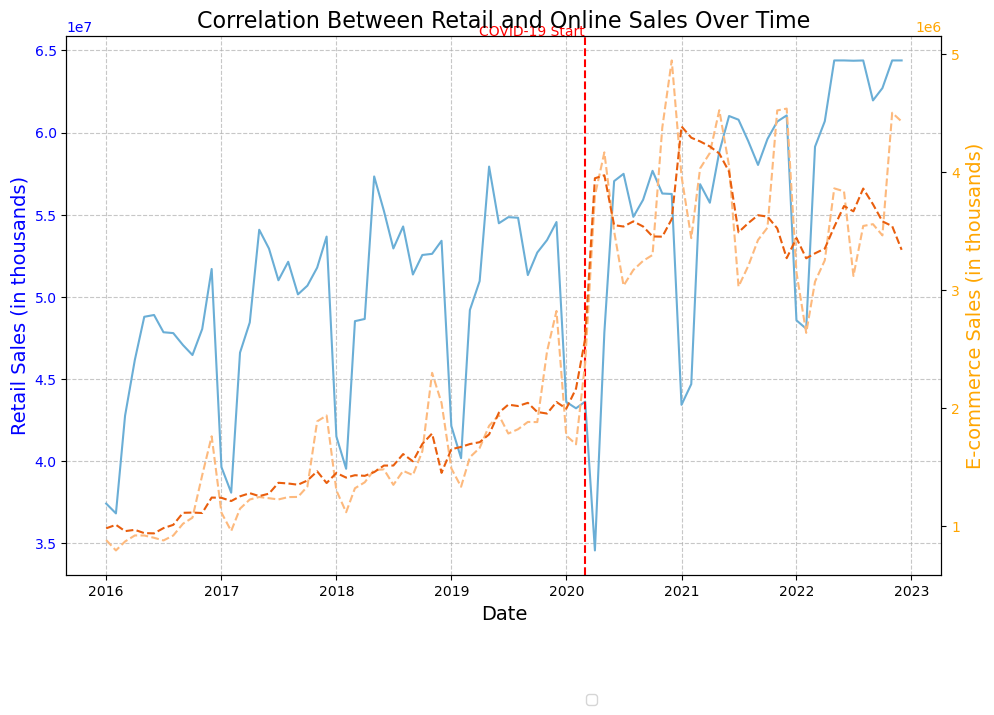

In [127]:
# Calculate cumulative sales for better trend analysis
cleaned_df['Cumulative_Sales'] = cleaned_df.groupby('Sales')['VALUE'].cumsum()

# Separate retail and e-commerce data for better visualization
retail_trade = cleaned_df[cleaned_df['Sales'].str.contains('Retail trade, unadjusted')]
ecommerce_sales = cleaned_df[cleaned_df['Sales'].str.contains('E-commerce')]

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot retail trade sales on the first y-axis
sns.lineplot(x='REF_DATE', y='VALUE', hue='Sales', data=retail_trade, ax=ax1, palette='Blues', linestyle='-', legend=False)
ax1.set_title('Correlation Between Retail and Online Sales Over Time', fontsize=16)
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Retail Sales (in thousands)', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a second y-axis for e-commerce sales
ax2 = ax1.twinx()
sns.lineplot(x='REF_DATE', y='VALUE', hue='Sales', data=ecommerce_sales, ax=ax2, palette='Oranges', linestyle='--', legend=False)
ax2.set_ylabel('E-commerce Sales (in thousands)', fontsize=14, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.grid(False)

# Combine legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
combined_legend = handles1 + handles2
combined_labels = labels1 + labels2

# Add vertical line for COVID-19 start
ax1.axvline(pd.to_datetime('2020-03-01'), color='red', linestyle='--')
ax1.text(pd.to_datetime('2020-03-01'), ax1.get_ylim()[1], 'COVID-19 Start', color='red', ha='right')

# Adjust layout to avoid overlap
fig.subplots_adjust(right=0.75)

# Add combined legend
fig.legend(combined_legend, combined_labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

# Display the plot
plt.show()

## General Observations
1. Correlation Between Retail and Online Sales Over Time:
oThe chart shows the correlation between retail sales (left y-axis) and 
online sales (right y-axis) from 2016 to 2023.
oA vertical red dashed line marks the start of COVID-19 in March 2020.
# Specific Observations
1. Pre-COVID-19 (2016 - Early 2020):
oRetail sales show a fluctuating pattern with seasonal peaks and 
troughs.
oOnline sales also show a gradual increase with some fluctuations, often
following similar trends to retail sales but on a smaller scale.
2. During and Post-COVID-19 (March 2020 - 2023):
oRetail Sales: Noticeable dip at the start of COVID-19, followed by a 
recovery and a continued upward trend.
oOnline Sales: Significant increase at the start of COVID-19, with 
fluctuations indicating variable consumer behavior.
# Insights
1. Impact of COVID-19:
oBoth retail and online sales experienced a significant impact at the 
onset of COVID-19. Retail sales initially dropped but recovered strongly,
while online sales saw a sharp increase, highlighting a shift in 
consumer behavior towards online shopping.
2. Correlation Trends:
oPost-COVID, there is a visible alignment in the trends of retail and 
online sales, suggesting that growth in one may influence or reflect 
growth in the other.
# Recommendations
1. For Retail Businesses:
oIntegrate online and offline sales strategies to leverage the correlation 
between the two.
oEnhance online presence to capture the shift towards online shopping.
2. For Analysts and Policy Makers:
oMonitor the interplay between retail and online sales to understand 
consumer behavior better.
oSupport businesses in enhancing their online infrastructure to handle 
future demand spikes.

In [128]:
# Step 1: Percentage Change in Sales (Pre COVID vs During COVID)
cleaned_df['Period'] = cleaned_df['REF_DATE'].apply(lambda x: 'During COVID' if x >= pd.to_datetime('2020-03-01') else 'Pre COVID')
sales_change = cleaned_df.groupby(['Sales', 'Period'])['VALUE'].sum().unstack().pct_change(axis='columns').iloc[:, 1] * 100
sales_change = sales_change.reset_index().rename(columns={0: 'Percentage Change'})
# Step 2: Cumulative Sales Over Time
cleaned_df['Cumulative_Sales'] = cleaned_df.groupby('Sales')['VALUE'].cumsum()
cumulative_sales = cleaned_df.pivot_table(values='Cumulative_Sales', index='REF_DATE', columns='Sales')
# Step 3: Distribution of Sales Before and During COVID-19
distribution = cleaned_df.groupby(['Sales', 'Period'])['VALUE'].describe().unstack()
# Step 4: Correlation Between Retail and Online Sales Over Time
correlation_data = cleaned_df.pivot_table(values='VALUE', index='REF_DATE', columns='Sales')
correlation = correlation_data.corr()
# Display tables
print("Percentage Change in Sales (Pre COVID vs During COVID)")
display(sales_change)
print("\nCumulative Sales Over Time")
display(cumulative_sales)
print("\nDistribution of Sales Before and During COVID-19")
display(distribution)
print("\nCorrelation Between Retail and Online Sales Over Time")
display(correlation)

Percentage Change in Sales (Pre COVID vs During COVID)


,Sales,Pre COVID
0,"Electronic shopping and mail-order houses, una...",-37.472722
1,"Retail E-commerce sales, seasonally adjusted",-41.102830
2,"Retail E-commerce sales, unadjusted",-42.035030
3,"Retail trade, unadjusted [44-453]",27.015275



Cumulative Sales Over Time


Sales,"Electronic shopping and mail-order houses, unadjusted [45411]","Retail E-commerce sales, seasonally adjusted","Retail E-commerce sales, unadjusted","Retail trade, unadjusted [44-453]"
REF_DATE,,,,
2016-01-01,6.796120e+05,977198.0,877354.0,3.741515e+07
2016-02-01,1.343923e+06,1983808.0,1666907.0,7.423113e+07
2016-03-01,2.025114e+06,2936994.0,2532584.0,1.169949e+08
2016-04-01,2.711878e+06,3901273.0,3449294.0,1.631508e+08
2016-05-01,3.393070e+06,4837639.0,4365538.0,2.119342e+08
...,...,...,...,...
2022-08-01,1.204108e+08,182674497.0,180997837.0,4.125729e+09
2022-09-01,1.228836e+08,186398536.0,184553257.0,4.187681e+09
2022-10-01,1.252209e+08,189977702.0,188013556.0,4.250384e+09



Distribution of Sales Before and During COVID-19


count            \
Period                                             During COVID Pre COVID   
Sales                                                                       
Electronic shopping and mail-order houses, unad...         34.0      50.0   
Retail E-commerce sales, seasonally adjusted               34.0      50.0   
Retail E-commerce sales, unadjusted                        34.0      50.0   
Retail trade, unadjusted [44-453]                          34.0      50.0   

                                                            mean  \
Period                                              During COVID   
Sales                                                              
Electronic shopping and mail-order houses, unad...  2.368131e+06   
Retail E-commerce sales, seasonally adjusted        3.643764e+06   
Retail E-commerce sales, unadjusted                 3.666841e+06   
Retail trade, unadjusted [44-453]                   5.673569e+07   

                                                                  \
Period                                                 Pre COVID   
Sales                                                              
Electronic shopping and mail-order houses, unad...  1.006895e+06   
Retail E-commerce sales, seasonally adjusted        1.459330e+06   
Retail E-commerce sales, unadjusted                 1.445329e+06   
Retail trade, unadjusted [44-453]                   4.900284e+07   

                                                             std  \
Period                                              During COVID   
Sales                                                              
Electronic shopping and mail-order houses, unad...  3.286370e+05   
Retail E-commerce sales, seasonally adjusted        3.584242e+05   
Retail E-commerce sales, unadjusted                 6.081189e+05   
Retail trade, unadjusted [44-453]                   7.261124e+06   

                                                                          min  \
Period                                                 Pre COVID During COVID   
Sales                                                                           
Electronic shopping and mail-order houses, unad...  3.149438e+05    1667146.0   
Retail E-commerce sales, seasonally adjusted        3.493746e+05    2583398.0   
Retail E-commerce sales, unadjusted                 4.433659e+05    2379817.0   
Retail trade, unadjusted [44-453]                   5.420745e+06   34561639.0   

                                                                         25%  \
Period                                                Pre COVID During COVID   
Sales                                                                          
Electronic shopping and mail-order houses, unad...    664310.95   2133557.75   
Retail E-commerce sales, seasonally adjusted          934274.00   3460315.75   
Retail E-commerce sales, unadjusted                   789553.00   3212412.75   
Retail trade, unadjusted [44-453]                   36815980.00  55770116.00   

                                                                         50%  \
Period                                                Pre COVID During COVID   
Sales                                                                          
Electronic shopping and mail-order houses, unad...    754893.75    2338858.0   
Retail E-commerce sales, seasonally adjusted         1236259.00    3571886.5   
Retail E-commerce sales, unadjusted                  1121025.00    3533152.0   
Retail trade, unadjusted [44-453]                   46491411.25   58422277.0   

                                                                        75%  \
Period                                               Pre COVID During COVID   
Sales                                                                         
Electronic shopping and mail-order houses, unad...    952351.5   2547635.25   
Retail E-commerce sales, seasonally adjusted         1424674.0   3824077.00   
Re


Correlation Between Retail and Online Sales Over Time


Sales,"Electronic shopping and mail-order houses, unadjusted [45411]","Retail E-commerce sales, seasonally adjusted","Retail E-commerce sales, unadjusted","Retail trade, unadjusted [44-453]"
Sales,,,,
"Electronic shopping and mail-order houses, unadjusted [45411]",1.000000,0.934447,0.982364,0.649605
"Retail E-commerce sales, seasonally adjusted",0.934447,1.000000,0.940794,0.532798
"Retail E-commerce sales, unadjusted",0.982364,0.940794,1.000000,0.610681
"Retail trade, unadjusted [44-453]",0.649605,0.532798,0.610681,1.000000


In [129]:
#Resources:

file_us = os.path.join("Resources/supptsnotadjustedsales.csv")
file_us_df = pd.read_csv(file_us)

file_ca_retail = os.path.join("Resources/retail.csv")
file_ca_retail_df = pd.read_csv(file_ca_retail)
file_ca_retail_df = file_ca_retail_df.drop(columns=["SYMBOL", "TERMINATED", "STATUS"])
file_ca_retail_df = file_ca_retail_df.dropna(how='any')


file_ca_retail_df.info()
#file_us_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23948 entries, 0 to 31290
Data columns (total 15 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   REF_DATE                                               23948 non-null  object 
 1   GEO                                                    23948 non-null  object 
 2   DGUID                                                  23948 non-null  object 
 3   North American Industry Classification System (NAICS)  23948 non-null  object 
 4   Sales                                                  23948 non-null  object 
 5   Adjustments                                            23948 non-null  object 
 6   Release                                                23948 non-null  object 
 7   UOM                                                    23948 non-null  object 
 8   UOM_ID                                             

In [130]:
#Create Year Column in US Data:

file_us_df["Year"] = file_us_df["Quarter"].str[12:16]
file_us_df["Year"] = file_us_df["Year"].astype(int)
file_us_df["Sales"] = file_us_df["Sales"]/10000
file_us_df= file_us_df[file_us_df["Year"] != 2024]
file_us_df

,Quarter,Category,SubCategory,Sales,Year
21,4th quarter 2023,Total Store and\nNon-store\nSales,Total Retail Trade,189.258100,2023
22,4th quarter 2023,Total\nE-commerce,Total Retail Trade,32.286200,2023
23,4th quarter 2023,Total Store and\nNon-store\nSales,Motor vehicle\nand parts,38.331600,2023
24,4th quarter 2023,Total\nE-commerce,Motor vehicle\nand parts,1.391300,2023
25,4th quarter 2023,Total Store and\nNon-store\nSales,"Furniture, building materials,\nand electronics",20.799000,2023
...,...,...,...,...,...
595,2nd quarter 2018,Total Store and\nNon-store\nSales,Electronics and appliance,9.447151,2018
596,2nd quarter 2018,Total Store and\nNon-store\nSales,"Building materials,\ngarden equipment\nand sup...",4.401029,2018
597,1st quarter 2018,Total Store and\nNon-store\nSales,Furniture and\nhome\nfurnishings,2.520527,2018
598,1st quarter 2018,Total Store and\nNon-store\nSales,Electronics and appliance,8.305272,2018


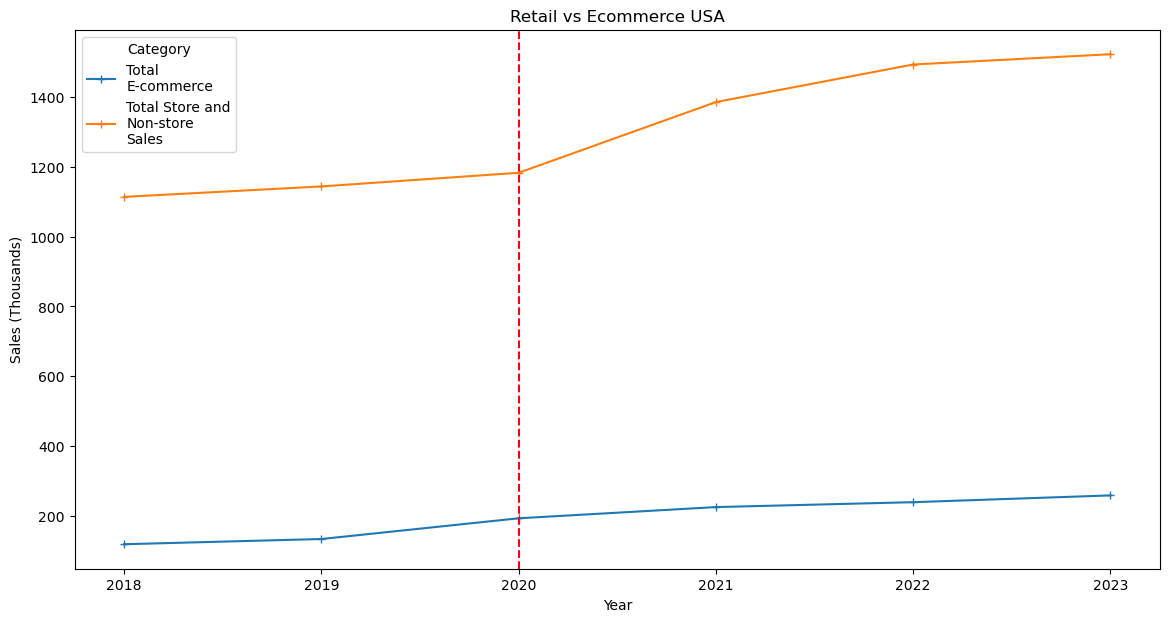

In [131]:
#Comparison between Retail and Ecommenrce USA:

category_sales = file_us_df.groupby(["Year","Category"])["Sales"].sum().unstack()

category_sales.plot(figsize=(14, 7), marker="+")


plt.axvline(2020, color='red', linestyle='--', label='COVID Start (March 2020)')
plt.xlabel('Year')
plt.ylabel('Sales (Thousands)')
plt.title('Retail vs Ecommerce USA')
plt.show()

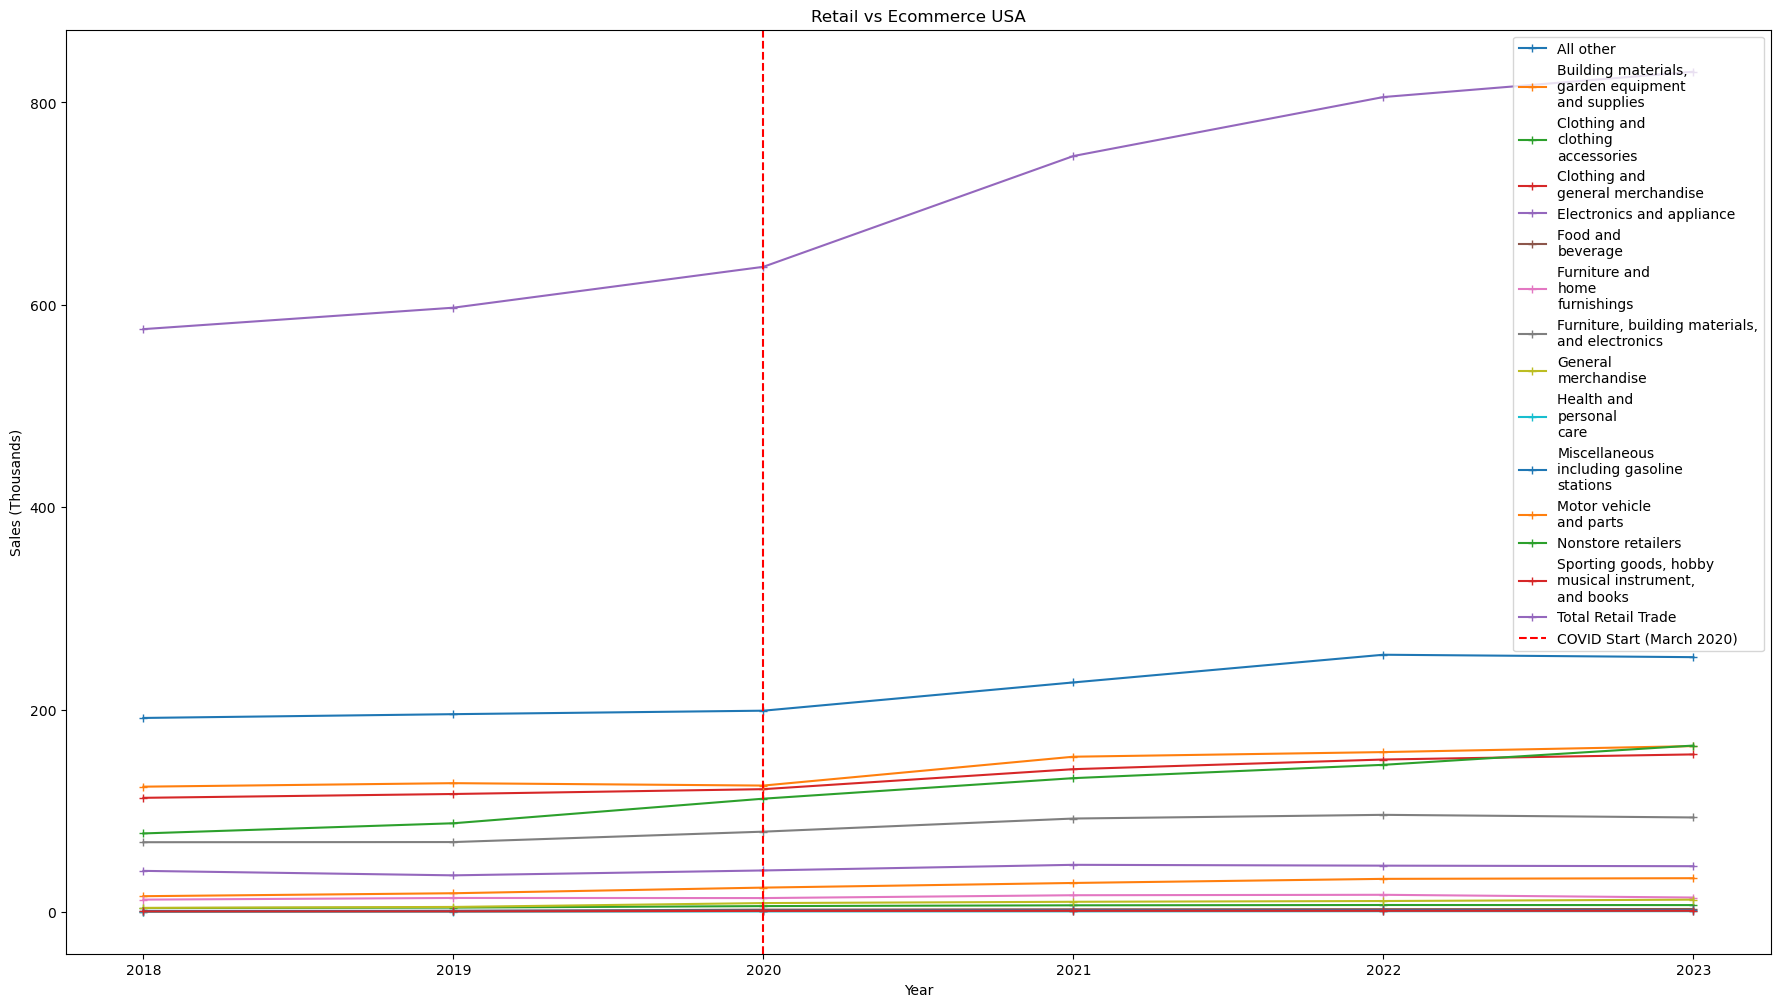

In [132]:
category_sales = file_us_df.groupby(["Year","SubCategory"])["Sales"].sum().unstack()

category_sales.plot(figsize=(22, 12), marker="+")

plt.axvline(2020, color='red', linestyle='--', label='COVID Start (March 2020)')
plt.xlabel('Year')
plt.ylabel('Sales (Thousands)')
plt.title('Retail vs Ecommerce USA')
plt.legend(loc='upper right')
plt.show()

## General Observation
Before the onset of the COVID-19 pandemic, the retail landscape in the United States exhibited stability across both traditional brick-and-mortar stores and online e-commerce platforms. However, the subsequent impact of COVID-19 resulted in substantial shifts within these sectors.

As of the latest available data, the retail sector continues to reflect these post-COVID-19 shifts. Retail sales have shown resilience and recovery, with a pronounced increase compared to pre-pandemic levels. This growth is particularly evident in sectors catering to electronics, and wellness products, which saw sustained demand during and after the pandemic. In contrast, while e-commerce growth remains robust, it has stabilized somewhat as initial pandemic-driven surges normalize. E-commerce platforms have adapted by enhancing user interfaces, expanding product offerings, and improving logistical capabilities to sustain consumer interest and retention.

/var/folders/0r/j22hntp103nbknzwp2b4l7rh0000gn/T/ipykernel_1605/280393361.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  electronics_us["Country"] = "USA"
/var/folders/0r/j22hntp103nbknzwp2b4l7rh0000gn/T/ipykernel_1605/280393361.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  electronics_us["Year"] = file_us_df["Year"].astype(int)


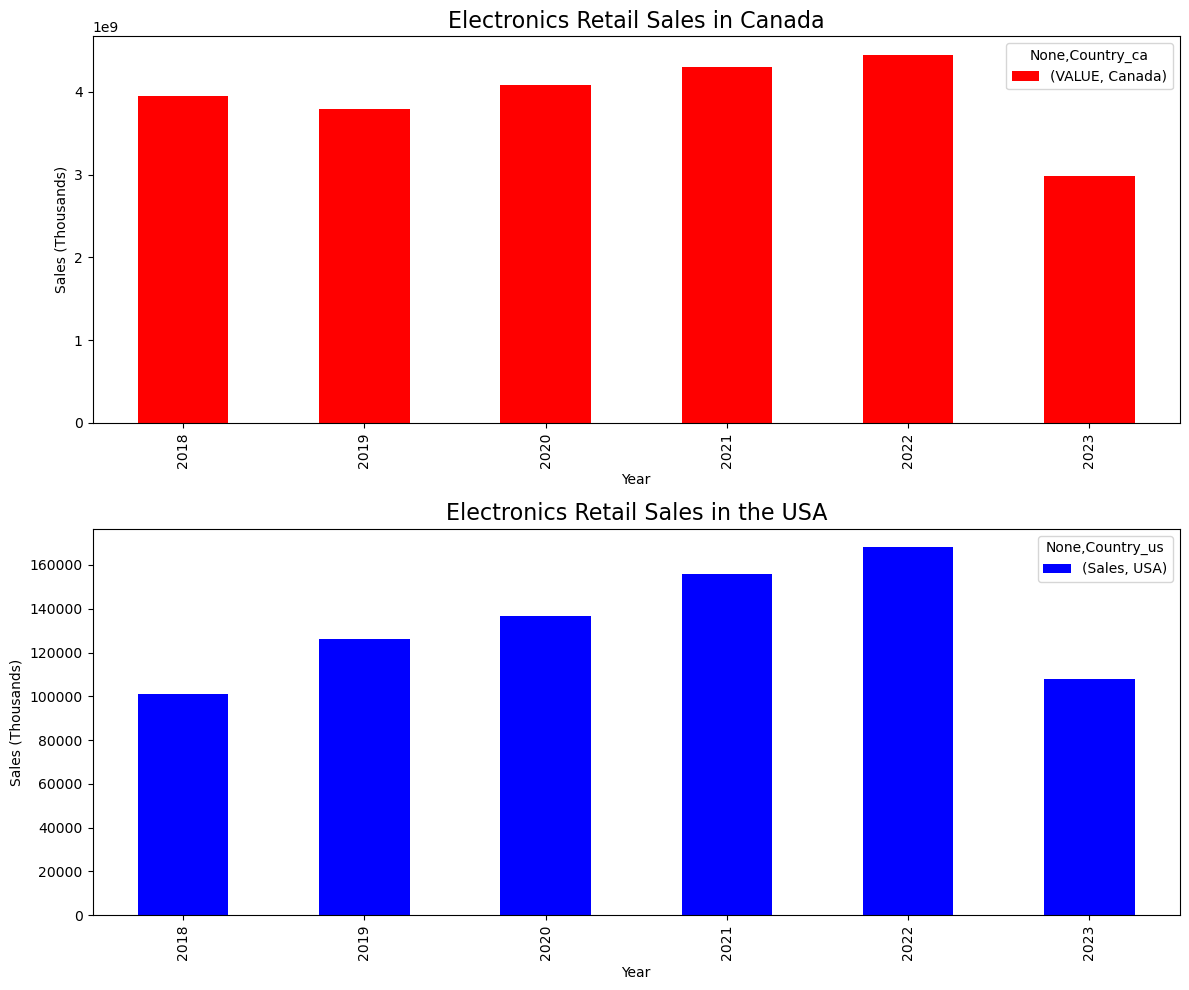

In [133]:
# Filter by Electronics in Retail Data (CA / USA)
electronics_ca = file_ca_retail_df[file_ca_retail_df["North American Industry Classification System (NAICS)"] == "Electronics and appliances retailers [4492]"]
electronics_us = file_us_df[(file_us_df["SubCategory"] == "Electronics and appliance") & (file_us_df["Category"] == "Total Store and\nNon-store\nSales")]

# Add Country and Year columns
electronics_ca["Country"] = "Canada"
electronics_us["Country"] = "USA"
electronics_ca["Year"] = file_ca_retail_df["REF_DATE"].str[0:4].astype(int)
electronics_us["Year"] = file_us_df["Year"].astype(int)

# Rename column to Subcategory
electronics_ca = electronics_ca.rename(columns={"North American Industry Classification System (NAICS)": "SubCategory"})
electronics_ca = electronics_ca.replace("Electronics and appliances retailers [4492]", "Electronics and appliance")

# Select relevant columns
electronics_ca_sales = electronics_ca[["SubCategory", "Country", "Year", "VALUE"]]
electronics_us_sales = electronics_us[["SubCategory", "Country", "Year", "Sales"]]

# Merge the two dataframes on Year
electronics_sales = pd.merge(electronics_ca_sales, electronics_us_sales, on="Year", suffixes=('_ca', '_us'))

# Group by Year and Country, then sum the sales values
electronics_sales_ca = electronics_sales.groupby(["Year", "Country_ca"])[["VALUE"]].sum().unstack()
electronics_sales_us = electronics_sales.groupby(["Year", "Country_us"])[["Sales"]].sum().unstack()

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

electronics_sales_ca.plot(kind="bar", ax=ax[0], color="r")
ax[0].set_title('Electronics Retail Sales in Canada', fontsize=16)
ax[0].set_xlabel('Year', fontsize=10)
ax[0].set_ylabel('Sales (Thousands)', fontsize=10)

electronics_sales_us.plot(kind="bar", ax=ax[1], color="b")
ax[1].set_title('Electronics Retail Sales in the USA', fontsize=16)
ax[1].set_xlabel('Year', fontsize=10)
ax[1].set_ylabel('Sales (Thousands)', fontsize=10)

plt.tight_layout()
plt.show()



## General Observation
The electronics sales industry has shown notable resilience and growth both before and after the onset of the COVID-19 pandemic. In both the United States and Canada, this sector emerged as a leading contributor to overall retail sales. However, a closer examination reveals a fluctuating trend over recent years.

In the United States, electronics sales experienced a significant surge during the peak of the pandemic in 2020, driven by increased demand for remote work and home entertainment solutions. This trend continued into 2021, with 2022 marking the pinnacle of sales performance. Despite these highs, 2023 witnessed a notable decline, comparable to levels observed in 2018, indicating a potential stabilization or market correction post-pandemic.

Similarly, in Canada, the electronics sales sector followed a parallel trajectory. The industry saw robust growth during the pandemic years, reaching its zenith in 2022. However, like its American counterpart, 2023 saw a downturn, echoing sales figures from earlier in the decade.

Looking ahead, the electronics sales industry in both countries faces the dual challenge of adapting to post-pandemic consumer preferences while navigating global supply chain disruptions and economic uncertainties. Strategic initiatives focusing on innovation, product diversification, and digital transformation will be pivotal in sustaining growth and resilience in the evolving retail landscape.

### API: Retail Sales after Covid-19 in Provinces

In [134]:
# Load sales data
sales_data = pd.read_csv('Resources/provincesales.csv')

# Display the first few rows to verify data loading
sales_data.head()

,REF_DATE,GEO,DGUID,North American Industry Classification System (NAICS),Adjustments,UOM,UOM_ID,SCALAR_FACTOR,VECTOR,VALUE
0,2022-08,Newfoundland and Labrador,2016A000210,Retail trade [44-45],Seasonally adjusted,Dollars,81,thousands,v52367394,931693
1,2022-09,Newfoundland and Labrador,2016A000210,Retail trade [44-45],Seasonally adjusted,Dollars,81,thousands,v52367394,916938
2,2022-10,Newfoundland and Labrador,2016A000210,Retail trade [44-45],Seasonally adjusted,Dollars,81,thousands,v52367394,941077
3,2022-11,Newfoundland and Labrador,2016A000210,Retail trade [44-45],Seasonally adjusted,Dollars,81,thousands,v52367394,915038
4,2022-12,Newfoundland and Labrador,2016A000210,Retail trade [44-45],Seasonally adjusted,Dollars,81,thousands,v52367394,921506


In [135]:
# Calculate total sales per province
total_sales_per_province = sales_data.groupby('GEO')['VALUE'].sum().reset_index()

# Rename columns for clarity
total_sales_per_province.columns = ['Province', 'Total_Sales']

# Print aggregated sales data per province
print(total_sales_per_province)


                     Province  Total_Sales
0                     Alberta     40345861
1            British Columbia     42388404
2                    Manitoba     10901997
3               New Brunswick      6865865
4   Newfoundland and Labrador      4626252
5       Northwest Territories       362631
6                 Nova Scotia      8351720
7                     Nunavut       242232
8                     Ontario    112258393
9        Prince Edward Island      1376319
10                     Quebec     69583629
11               Saskatchewan     10474125
12                      Yukon       428019


In [136]:
# Dictionary of provinces and their capitals
province_capitals = {
    "Newfoundland and Labrador": "St. John's",
    "Prince Edward Island": "Charlottetown",
    "Nova Scotia": "Halifax",
    "New Brunswick": "Fredericton",
    "Quebec": "Quebec City",
    "Ontario": "Toronto",
    "Manitoba": "Winnipeg",
    "Saskatchewan": "Regina",
    "Alberta": "Edmonton",
    "British Columbia": "Victoria",
    "Yukon": "Whitehorse",
    "Northwest Territories": "Yellowknife",
    "Nunavut": "Iqaluit"
}

# Function to retrieve coordinates of province capitals using Geoapify
def get_province_capital_coordinates(province):
    api_key = '6ce614d6f6b546fbb217a25ed2844d6c'
    url = 'https://api.geoapify.com/v1/geocode/search'
    capital = province_capitals.get(province, province)  # Default to province name if capital not found
    params = {
        'text': f'{capital}, Canada',
        'apiKey': api_key
    }
    response = requests.get(url, params=params)
    data = response.json()
    # Debug statements removed
    if response.status_code != 200:
        # Error handling removed
        return None
    if 'features' not in data or not data['features']:
        # Handling when no coordinates found removed
        return None
    coordinates = data['features'][0]['geometry']['coordinates']
    return coordinates[::-1]  # Geoapify returns [lon, lat], convert to [lat, lon]

# Iterate over provinces and retrieve coordinates
coordinates_data = []
for province in province_capitals:
    coordinates = get_province_capital_coordinates(province)
    if coordinates:
        coordinates_data.append({
            'Province': province,
            'Capital': province_capitals[province],
            'Coordinates': coordinates
        })

# Now you can process or display the coordinates_data as needed
for data in coordinates_data:
    print(f"Coordinates of {data['Province']} capital ({data['Capital']}): {data['Coordinates']}")

Coordinates of Newfoundland and Labrador capital (St. John's): [47.5614705, -52.7126162]
Coordinates of Prince Edward Island capital (Charlottetown): [46.234953, -63.132935]
Coordinates of Nova Scotia capital (Halifax): [44.648618, -63.5859487]
Coordinates of New Brunswick capital (Fredericton): [45.9348018, -66.65564360948193]
Coordinates of Quebec capital (Quebec City): [46.8137431, -71.2084061]
Coordinates of Ontario capital (Toronto): [43.6534817, -79.3839347]
Coordinates of Manitoba capital (Winnipeg): [49.8955367, -97.1384584]
Coordinates of Saskatchewan capital (Regina): [50.44876, -104.61731]
Coordinates of Alberta capital (Edmonton): [53.5462055, -113.491241]
Coordinates of British Columbia capital (Victoria): [48.4283182, -123.364953]
Coordinates of Yukon capital (Whitehorse): [60.721571, -135.054932]
Coordinates of Northwest Territories capital (Yellowknife): [62.4540807, -114.377385]
Coordinates of Nunavut capital (Iqaluit): [63.7492738, -68.5213763]


In [137]:
# Apply the function to the DataFrame to get coordinates
total_sales_per_province['Coordinates'] = total_sales_per_province['Province'].apply(get_province_capital_coordinates)

# Divide coordinates into 'lat' and 'lon'
total_sales_per_province['lat'] = total_sales_per_province['Coordinates'].apply(lambda x: x[0] if x else None)
total_sales_per_province['lon'] = total_sales_per_province['Coordinates'].apply(lambda x: x[1] if x else None)

# Display the DataFrame to see if coordinates were assigned
print("Data with coordinates:")
print(total_sales_per_province)

# Optionally, display the first few rows of the DataFrame
print("\nFirst few rows:")
print(total_sales_per_province.head())

Data with coordinates:
                     Province  Total_Sales                       Coordinates  \
0                     Alberta     40345861         [53.5462055, -113.491241]   
1            British Columbia     42388404         [48.4283182, -123.364953]   
2                    Manitoba     10901997         [49.8955367, -97.1384584]   
3               New Brunswick      6865865  [45.9348018, -66.65564360948193]   
4   Newfoundland and Labrador      4626252         [47.5614705, -52.7126162]   
5       Northwest Territories       362631         [62.4540807, -114.377385]   
6                 Nova Scotia      8351720          [44.648618, -63.5859487]   
7                     Nunavut       242232         [63.7492738, -68.5213763]   
8                     Ontario    112258393         [43.6534817, -79.3839347]   
9        Prince Edward Island      1376319           [46.234953, -63.132935]   
10                     Quebec     69583629         [46.8137431, -71.2084061]   
11               

In [138]:
# Plotting the map using hvplot with total_sales_per_province DataFrame
map_plot = total_sales_per_province.hvplot.points(
    'lon', 'lat', geo=True, tiles='OSM',
    # frame_width=800, frame_height=600,
    title='Province Capitals in Canada'
)

# Display the map plot
map_plot

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [lon,lat]


## General Observation:
Ontario and Quebec lead in total sales with $112,258,393 and $69,583,629 respectively, demonstrating their significant economic contributions. Conversely, the Northwest Territories, Nunavut, and Yukon have the lowest sales figures, highlighting regional disparities in sales performance across Canada.

In [139]:
# Plotting the map using hvplot
map_plot_2 = total_sales_per_province.hvplot.points(
    'lon', 'lat', geo=True,
    frame_width=800, frame_height=600,
    tiles='OSM',
    size='Sales',  # Assuming 'Sales' represents the size of the points
    scale=0.5,
    color='Province',  # Assuming you want to color by Province
    title='Province Capitals in Canada',
    hover_cols = ["Capital", "Total_Sales"]
)
# Display the map plot
map_plot_2

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [lon,lat]   (Province,Total_Sales)

## Synopsis and Analysis of Retail Sales Trends During Covid-19
This examination analyzes the effect of Coronavirus on retail sales trends, contrasting online and traditional in-store channels. Here are the key takeaways:

### Overall Trends:

Retail Sales Resilience: In spite of a plunge at the pandemic's beginning, retail sales (including physical stores) recovered and kept on developing, exhibiting the industry's flexibility.
Shift to Online, Yet Not a Takeover: Online sales expanded during Coronavirus, yet the development was not so dramatic as expected. This suggests many customers still prefer in-store shopping to some degree.
Pre- vs. During/Post-COVID:

Pre-COVID: Retail sales showed seasonal patterns, with online sales remaining somewhat steady and low compared to physical stores.
During/Post-COVID: Retail sales dipped initially but returned. Online sales showed an unassuming but consistent rise, mirroring a change in buyer conduct.

Development Rates:
Year-over-year development rates offer a clearer picture of sales trends. While pre-Coronavirus rates were mostly positive, there were variances. The pandemic caused a sharp decrease in development rates in 2020, followed by a strong recovery with some months encountering high growth (2021). Development rates in 2022 suggest a return to more stable patterns.
Influence on E-commerce:

Curiously, notwithstanding beginning assumptions, e-commerce categories encountered a decrease in sales during the underlying phases of Coronavirus. This could be because of elements like supply chain disruptions or introductory purchaser conduct changes.

### Conclusion:
Key insights from this analysis reveal the adaptability of retail trade in the face of significant disruptions and the gradual, though not overwhelming, shift towards e-commerce. To thrive in this evolving landscape, traditional retailers should invest in hybrid shopping models that blend physical and digital experiences, enhancing their resilience to future disruptions. Online retailers, meanwhile, should focus on scaling up their infrastructure and optimizing marketing strategies during peak periods to better serve the increased demand. Overall, the pandemic has underscored the importance of flexibility, innovation, and a balanced approach to integrating online and in-store shopping experiences in the retail sector.